In [1]:
# ubuntu
!sudo apt install -y tesseract-ocr
# python
!pip install pytesseract transformers datasets seqeval tensorboard --upgrade

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [2]:
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
#dataset_id ="nielsr/funsd"
dataset_id ="nielsr/funsd-layoutlmv3"

In [5]:
from datasets import load_dataset


dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 149
Test dataset size: 50


In [6]:
train_datasets_sampled =  dataset["train"].shuffle(seed=42).select(range(5))
eval_dataset_sampled = dataset["test"].shuffle(seed=42).select(range(2))

In [7]:
print(train_datasets_sampled)

Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 5
})


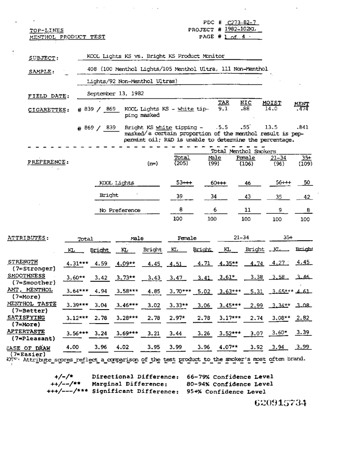

In [9]:
from PIL import Image, ImageDraw, ImageFont

image = train_datasets_sampled[2]['image']
image = image.convert("RGB")
image.resize((350,450))

In [10]:
labels = train_datasets_sampled.features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [11]:
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor

model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False) # set
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


In [12]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(feature=Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        sample["image"].convert("RGB"),
        sample["tokens"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    # remove pixel values not needed for LiLT
    del encoding["pixel_values"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = train_datasets_sampled.map(
    partial(process, processor=processor),
    remove_columns=["image", "tokens", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

proc_test_dataset = eval_dataset_sampled.map(
    partial(process, processor=processor),
    remove_columns=["image", "tokens", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset.features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels'])


In [13]:
train_datasets_sampled, dataset['train']

(Dataset({
     features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
     num_rows: 5
 }),
 Dataset({
     features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
     num_rows: 149
 }))

In [14]:
from transformers import LiltForTokenClassification

# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"

# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
%pip install evaluate

In [16]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])

In [17]:
pip install accelerate -U

In [18]:
! pip install -U accelerate
! pip install -U transformers

In [19]:
pip install transformers[torch]

In [20]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

# hugging face parameter
repository_id = "lilt-en-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # fp16=True,
    learning_rate=5e-5,
    max_steps=2500,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=200,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset,
    eval_dataset=proc_test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Start training
trainer.train()

Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Answer,Header,Question,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
200,0.086900,1.427698,"{'precision': 0.4473684210526316, 'recall': 0.68, 'f1': 0.5396825396825397, 'number': 25}","{'precision': 0.4, 'recall': 0.6666666666666666, 'f1': 0.5, 'number': 3}","{'precision': 0.75, 'recall': 0.8076923076923077, 'f1': 0.7777777777777779, 'number': 26}",0.563380,0.740741,0.640000,0.730205


Trainer is attempting to log a value of "{'precision': 0.4473684210526316, 'recall': 0.68, 'f1': 0.5396825396825397, 'number': 25}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.4, 'recall': 0.6666666666666666, 'f1': 0.5, 'number': 3}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.75, 'recall': 0.8076923076923077, 'f1': 0.7777777777777779, 'number': 26}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [ ]:
trainer.evaluate()

In [ ]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

In [ ]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("philschmid/lilt-en-funsd")
processor = LayoutLMv3Processor.from_pretrained("philschmid/lilt-en-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(train_datasets_sampled[2]["image"])